In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import login
from google.colab import userdata

token = userdata.get('hf_token')

login(token=token)

print("Logged into Hugging Face!")


Logged into Hugging Face!


In [ ]:
!pip3 install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

def load_tsv(filepath):
    """
    Load a TSV file into a pandas DataFrame.
    Args:
        filepath (str): Path to the TSV file.
    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    return pd.read_csv(filepath, sep="\t")

train_tsv_path = "/content/drive/MyDrive/orientation-tr-train.tsv"
test_tsv_path = "/content/drive/MyDrive/orientation-tr-test.tsv"

# Load training and test datasets
train_data = load_tsv(train_tsv_path)
test_data = load_tsv(test_tsv_path)


In [ ]:
# Number of unique speakers
num_speakers = train_data["speaker"].nunique()
print(f"Number of unique speakers: {num_speakers}")

Number of unique speakers: 1042


In [ ]:
# Count of data points per speaker
speaker_counts = train_data["speaker"].value_counts()
print("Top 10 speakers by data count:")
print(speaker_counts.head(10))

Top 10 speakers by data count:
speaker
b66fcf2a142082f14b81c4e2c02c130a    20
702d742f000ca6f6152a0baa84dd8610    20
677fc620a4622a21cb4a136cc8d7e000    20
a4faaeb9bb8eb8e72ed859cd3079ddcf    20
d4be1a2647282beabaae6388fce268d8    20
76d9bec259b27ee0302a1fe73f6dfa2b    20
5eac570dcc603a82354ec04b0e040b21    20
13c0ee42b7ec0517045c67b3897a7c51    20
cf7b9591a653d511b20ba49ffa7e20be    20
f35b040c66f36ed756906040302b5238    20
Name: count, dtype: int64


Sex distribution:
sex
M    13515
F     2623
Name: count, dtype: int64


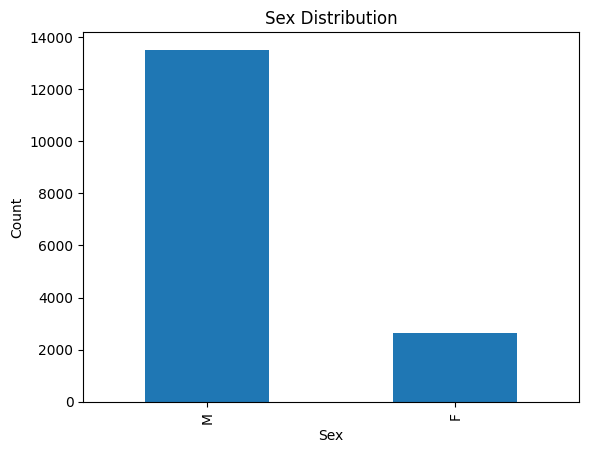

In [ ]:
# Sex distribution
sex_counts = train_data["sex"].value_counts()
print("Sex distribution:")
print(sex_counts)

# Plotting the sex distribution
import matplotlib.pyplot as plt

sex_counts.plot(kind='bar', title='Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()


Label distribution:
label
1    9390
0    6748
Name: count, dtype: int64


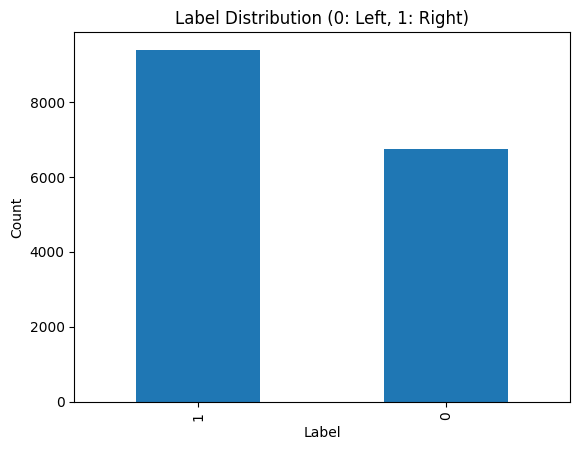

In [ ]:
# Label distribution
label_counts = train_data["label"].value_counts()
print("Label distribution:")
print(label_counts)

# Plotting the label distribution
label_counts.plot(kind='bar', title='Label Distribution (0: Left, 1: Right)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


Text length statistics:
count    16138.000000
mean      3189.863862
std       2989.387959
min        491.000000
25%        902.000000
50%       2400.000000
75%       4286.000000
max      19952.000000
Name: text_length, dtype: float64


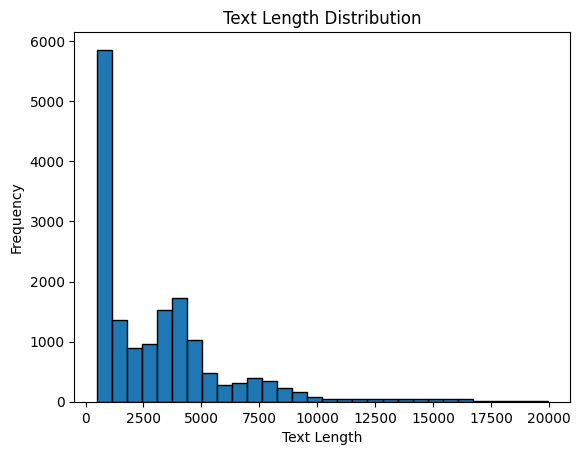

In [ ]:
# Calculate text lengths
train_data["text_length"] = train_data["text"].apply(len)

# Summary statistics for text length
print("Text length statistics:")
print(train_data["text_length"].describe())

# Plotting text length distribution
plt.hist(train_data["text_length"], bins=30, edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Overall dataset summary
print("Dataset Summary:")
print(train_data.info())
print(train_data.describe(include='all'))


Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           16138 non-null  object
 1   speaker      16138 non-null  object
 2   sex          16138 non-null  object
 3   text         16138 non-null  object
 4   text_en      16138 non-null  object
 5   label        16138 non-null  int64 
 6   text_length  16138 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 882.7+ KB
None
             id                           speaker    sex  \
count     16138                             16138  16138   
unique    16138                              1042      2   
top     tr16137  b66fcf2a142082f14b81c4e2c02c130a      M   
freq          1                                20  13515   
mean        NaN                               NaN    NaN   
std         NaN                               NaN    NaN   
min         NaN              

In [ ]:
# Check for missing values
missing_values = train_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
id             0
speaker        0
sex            0
text           0
text_en        0
label          0
text_length    0
dtype: int64


In [ ]:
train_split, validation_split = train_test_split(
    train_data,
    test_size=0.2,
    stratify=train_data["label"],
    random_state=42
)

# Check sizes
print(f"Training Data: {len(train_split)} samples")
print(f"Validation Data: {len(validation_split)} samples")


Training Data: 15331 samples
Validation Data: 807 samples


In [ ]:
def preprocess_data(data, tokenizer, is_test=False):
    """
    Preprocess and tokenize the dataset.
    Args:
        data (pd.DataFrame): Input DataFrame with 'text' (and optionally 'label') columns.
        tokenizer: Hugging Face tokenizer.
        is_test (bool): If True, processes the test dataset without labels.
    Returns:
        Dataset: Tokenized Hugging Face Dataset.
    """
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

    dataset = Dataset.from_pandas(data)

    # Tokenize the data
    dataset = dataset.map(tokenize_function, batched=True)

    # Format for PyTorch
    if not is_test:
        dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    else:
        dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

    return dataset

In [ ]:
# Initialize tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocess train and validation splits
train_dataset = preprocess_data(train_split, tokenizer)
validation_dataset = preprocess_data(validation_split, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/12910 [00:00<?, ? examples/s]

Map:   0%|          | 0/3228 [00:00<?, ? examples/s]

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes evaluation metrics including accuracy.
    Args:
        pred: Predictions from the model.
    Returns:
        dict: A dictionary with accuracy, precision, recall, and F1 score.
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=1)

    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
from transformers import EarlyStoppingCallback

# Load pre-trained multilingual model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Training arguments for XLM-R
training_args = TrainingArguments(
    lr_scheduler_type="cosine",
    warmup_steps=100,
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.06,
    logging_dir="./logs",
    save_strategy="epoch",
    fp16=True,
    load_best_model_at_end=True,
    report_to="none",
    logging_steps=50,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

)

# Fine-tune the model
trainer.train()


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-3a05387827c9>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.482900,0.369951,0.841698,0.866095,0.861022,0.863551
2,0.362200,0.345817,0.852230,0.923775,0.813099,0.864911
3,0.318300,0.317565,0.863693,0.903479,0.857295,0.879781
4,0.278000,0.329954,0.868959,0.899945,0.871672,0.885583
5,0.236000,0.337884,0.867100,0.892683,0.876997,0.884770


TrainOutput(global_step=4035, training_loss=0.3513285290648355, metrics={'train_runtime': 431.0342, 'train_samples_per_second': 149.756, 'train_steps_per_second': 9.361, 'total_flos': 1.6983818623488e+16, 'train_loss': 0.3513285290648355, 'epoch': 5.0})

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.31756454706192017, 'eval_accuracy': 0.8636926889714994, 'eval_precision': 0.9034792368125701, 'eval_recall': 0.8572949946751863, 'eval_f1': 0.8797814207650273, 'eval_runtime': 4.368, 'eval_samples_per_second': 739.014, 'eval_steps_per_second': 23.123, 'epoch': 5.0}


In [ ]:
from google.colab import drive
import json

# Path to save the file in Google Drive
output_path = "/content/drive/MyDrive/evaluation_results_task1_xlm_tr.json"

# Save evaluation results to Google Drive
with open(output_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"Evaluation results saved to '{output_path}'.")


Evaluation results saved to '/content/drive/MyDrive/evaluation_results_task1_xlm_tr.json'.


In [ ]:
# Preprocess test data
test_dataset = preprocess_data(test_data, tokenizer, True)

# Perform inference
test_predictions = trainer.predict(test_dataset)
test_data["predictions"] = test_predictions.predictions.argmax(axis=1)

# Path to save the file in Google Drive
output_path = "/content/drive/MyDrive/test_predictions.csv"

# Save test predictions to Google Drive
test_data[["id", "text", "predictions"]].to_csv(output_path, index=False)

print(f"Test predictions saved to '{output_path}'.")



Map:   0%|          | 0/2008 [00:00<?, ? examples/s]

Test predictions saved to '/content/drive/MyDrive/test_predictions.csv'.


In [ ]:
# Perform inference on the test dataset
predictions = trainer.predict(test_dataset)

# Extract predicted labels
predicted_labels = predictions.predictions.argmax(axis=1)

# Count occurrences of 0 and 1
label_counts = pd.Series(predicted_labels).value_counts()

# Display the counts
print(f"Predicted Label Counts:")
print(f"Label 0 (Left): {label_counts.get(0, 0)}")
print(f"Label 1 (Right): {label_counts.get(1, 0)}")


Predicted Label Counts:
Label 0 (Left): 1019
Label 1 (Right): 989
